In [15]:
# load shedding data
from glob import glob
import json
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as st

from distfit import distfit

import os
# install the shedding package from https://github.com/tillahoffmann/shedding.git
# navigate to the shedding package folder
#os.chdir('../shedding')
os.getcwd()

'/home/ec2-user/SageMaker/shedding'

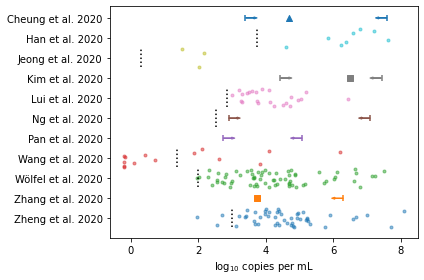

In [16]:
def to_float(x):
    return np.nan if x is None else x


np.random.seed(0)
spread = 0.45
arrow_kwargs = {
    'head_length': .1,
    'head_width': .1,
}
lim_length = 0.25
filenames = glob('publications/*/*.json')

fig, ax = plt.subplots()
ylabels = []
for i, filename in enumerate(sorted(filenames, reverse=True)):
    color = f'C{i}'

    with open(filename) as fp:
        publication = json.load(fp)
    ylabels.append(publication['key'])

    # Plot the level of quantification
    loq = publication['loq']
    if loq is not None:
        ax.plot((loq, loq), (i - spread, i + spread), ls=':', color='k')

    # Plot individual measurements
    loads = publication.get('loads')
    if loads:
        x = np.random.permutation([to_float(load['value']) for load in loads])
        y = i + np.linspace(-spread, spread, len(x))
        ax.scatter(x, y, color=color, marker='.', alpha=.5)

    # Plot limits
    summaries = publication.get('load_summaries', {})
    extremum_markers = []
    if 'max' in summaries:
        ax.arrow(summaries['max'], i, -lim_length, 0, color=color, **arrow_kwargs)
        extremum_markers.append(summaries['max'])
    if 'min' in summaries:
        ax.arrow(summaries['min'], i, lim_length, 0, color=color, **arrow_kwargs)
        extremum_markers.append(summaries['min'])
    if extremum_markers:
        ax.scatter(extremum_markers, i * np.ones_like(extremum_markers), color=color, marker='|')

    # Plot other summary statistics
    for key, marker in [('mean', 's'), ('median', '^')]:
        if key in summaries:
            ax.scatter(summaries[key], i, marker=marker, color=color)

ax.yaxis.set_ticks(np.arange(len(ylabels)))
ax.yaxis.set_ticklabels(ylabels)
ax.set_xlabel(r'$\log_{10}$ copies per mL')
fig.tight_layout()

In [17]:
# store the data
filenames = glob('publications/*/*.json')

x = []
for i, filename in enumerate(filenames):

    with open(filename) as fp:
        loads = json.load(fp).get('loads')

        if loads:
            x.append([to_float(load['value']) for load in loads])

x = [item for elem in x for item in elem]

x = np.array(x)
x_nat = np.where(x>0, 10**(x), x)

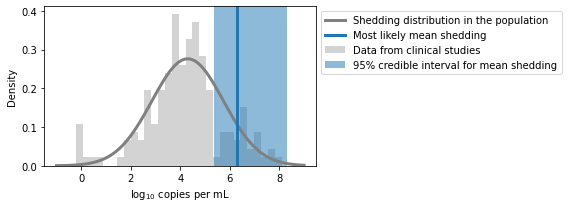

In [18]:
plt.figure(figsize=(8,3))
plt.hist(x, bins=30, density=True,color='lightgrey', label='Data from clinical studies')
plt.xlabel('log$_{10}$ copies per mL')
plt.ylabel('Density')

xp = np.linspace(-1,9,100)
yp = st.norm.pdf(x=xp, loc=4.300, scale=1.444)
plt.plot(xp, yp,color='grey',linewidth=3, label='Shedding distribution in the population')
plt.axvline(x=np.log10(1.9e6), linewidth=3, color='C0',label='Most likely mean shedding')
plt.axvspan(np.log10(2.3e5), np.log10(2.0e8), alpha=0.5, color='C0', linewidth=0, label='95% credible interval for mean shedding')
plt.legend(bbox_to_anchor=[1,1])
plt.tight_layout()
#plt.savefig('../uncertainty/figures/shedding_distribution.png',dpi=300)

(array([159.,   3.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([-2.12708143e-01,  1.22507108e+07,  2.45014219e+07,  3.67521329e+07,
         4.90028440e+07,  6.12535550e+07,  7.35042661e+07,  8.57549771e+07,
         9.80056881e+07,  1.10256399e+08,  1.22507110e+08]),
 <BarContainer object of 10 artists>)

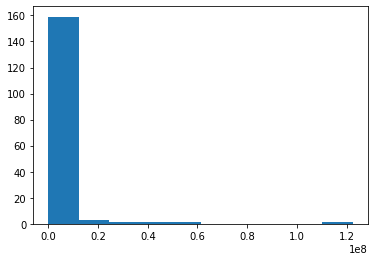

In [19]:
plt.hist(x_nat)

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.3182621] [loc=4.300 scale=1.444]
[distfit] >[expon     ] [0.00 sec] [RSS: 1.1611475] [loc=0.099 scale=4.202]
[distfit] >[pareto    ] [0.09 sec] [RSS: 1.1365435] [loc=-333941890.634 scale=333941890.732]
[distfit] >[dweibull  ] [0.01 sec] [RSS: 0.2492178] [loc=4.189 scale=1.169]
[distfit] >[t         ] [0.06 sec] [RSS: 0.2970798] [loc=4.278 scale=1.309]
[distfit] >[genextreme] [0.06 sec] [RSS: 0.3221261] [loc=3.774 scale=1.430]
[distfit] >[gamma     ] [0.07 sec] [RSS: 0.3124057] [loc=-22.956 scale=0.076]
[distfit] >[lognorm   ] [0.12 sec] [RSS: 0.3122040] [loc=-35.719 scale=39.993]
[distfit] >[beta      ] [0.10 sec] [RSS: 0.3125636] [loc=-23.773 scale=55762835.382]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.8107298] [loc=0.099 scale=7.990]
[distfit] >[loggamma  ] [0.07 sec] [RSS: 0.3216251] [loc=-352.413 scale=50.339]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


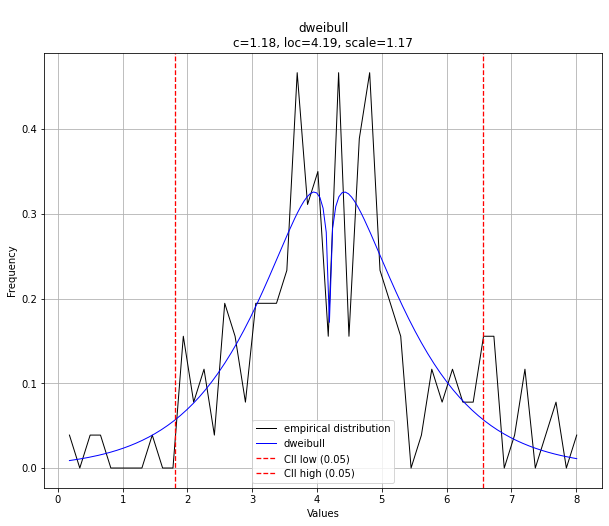

[distfit] >plot summary..


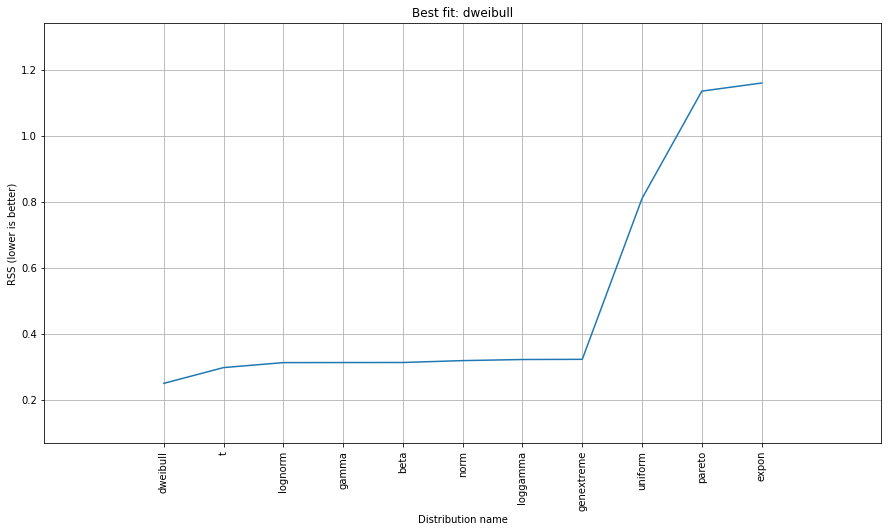

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Best fit: dweibull'}, xlabel='Distribution name', ylabel='RSS (lower is better)'>)

In [20]:
# Initialize
dist = distfit()

# Search for best theoretical fit on your emperical data
dist.fit_transform(x[x>0])

# Plot
dist.plot()

# summay plot
dist.plot_summary()

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0000000] [loc=2254881.244 scale=11332048.211]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0000000] [loc=1.255 scale=2254879.989]
[distfit] >[pareto    ] [0.02 sec] [RSS: 0.0000000] [loc=0.002 scale=1.253]
[distfit] >[dweibull  ] [0.06 sec] [RSS: 0.0000000] [loc=102.329 scale=1953414.850]
[distfit] >[t         ] [0.06 sec] [RSS: 0.0000000] [loc=2851.065 scale=4156.476]
[distfit] >[genextreme] [0.25 sec] [RSS: 0.0000000] [loc=4.595 scale=21.393]
[distfit] >[gamma     ] [0.09 sec] [RSS: 0.0000000] [loc=1.255 scale=57921843.498]
[distfit] >[lognorm   ] [0.13 sec] [RSS: 0.0000000] [loc=1.117 scale=19583.613]
[distfit] >[beta      ] [0.13 sec] [RSS: 0.0000000] [loc=1.255 scale=1082518121.880]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0000000] [loc=1.255 scale=122507108.978]
[distfit] >[loggamma  ] [0.07 sec] [RSS: 0.0000000] [loc=-3936034242.488 scale=521440874.910]
[distfit] >Compute confidence interval [para

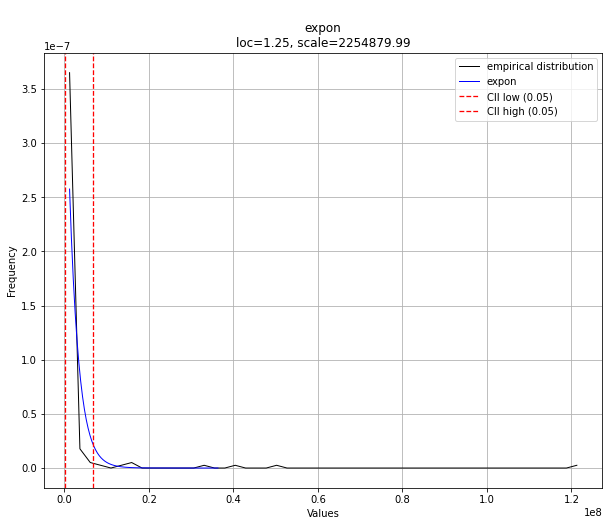

[distfit] >plot summary..


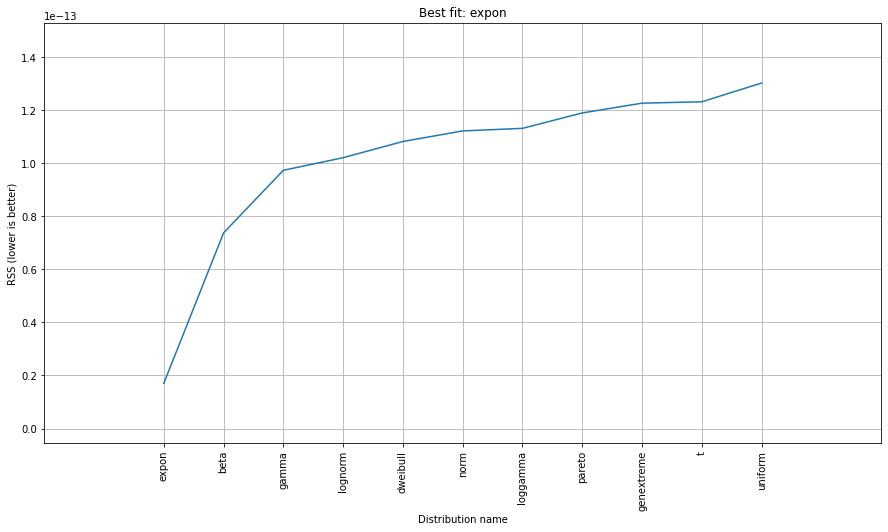

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Best fit: expon'}, xlabel='Distribution name', ylabel='RSS (lower is better)'>)

In [21]:
# Initialize
dist = distfit()

# Search for best theoretical fit on your emperical data
dist.fit_transform(x_nat[x_nat>0])

# Plot
dist.plot()

# summay plot
dist.plot_summary()